<a href="https://colab.research.google.com/github/ElenaVillano/sentiment_analysis_tweets/blob/main/notebooks/modelado_semifinal_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install "git+https://github.com/ElenaVillano/sentiment_analysis_tweets.git#egg=nlptweet&subdirectory=src" --quiet

In [6]:
import pandas as pd
import numpy as np
# Nuestro paquete
import nlp

In [ ]:
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet
             'date',   # Fecha y hora del tweet
             'flag',   # QUERY
             'user',   # Usuario del tweet
             'text']   # Texto del tweet

In [ ]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


In [ ]:
data_raw =  pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', names=col_names)

In [ ]:
from nlp.preprocessing import convierte_a_minusculas, quitar_caracteres_html, reemplazar_urls, reemplazar_usuarios,\
quitar_hashtag, quitar_RT, quitar_caracteres_especiales, quitar_letras_repetidas, quitar_nonascii, \
separar_abreviaciones, remove_stopwords, oracion_raiz, modificar_etiqueta

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = convierte_a_minusculas(data_raw)
data['text'] = data['text'].map(lambda s: quitar_caracteres_html(s))
data['text'] = data['text'].map(lambda s: reemplazar_urls(s))
data['text'] = data['text'].map(lambda s: reemplazar_usuarios(s))
data['text'] = data['text'].map(lambda s: quitar_hashtag(s))
data['text'] = data['text'].map(lambda s: quitar_RT(s))
data['text'] = data['text'].map(lambda s: quitar_caracteres_especiales(s))
data['text'] = data['text'].map(lambda s: quitar_letras_repetidas(s))
data['text'] = data['text'].map(lambda s: quitar_nonascii(s))
data['text'] = data['text'].map(lambda s: separar_abreviaciones(s))
data['text'] = data['text'].map(lambda s: remove_stopwords(s))
data['text'] = data['text'].map(lambda s: oracion_raiz(s))
data = modificar_etiqueta(data)

In [ ]:
data['text_raw'] = data_raw['text']

In [ ]:
data.to_csv("1600000_datos_limpios_sin_user_ni_url_sep.csv", sep="|", index=False, encoding="utf-8")


# Carga de datos limpios

In [2]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving 1600000_datos_limpios_sin_user_ni_url.csv to 1600000_datos_limpios_sin_user_ni_url.csv


In [7]:
data = pd.read_csv('1600000_datos_limpios_sin_user_ni_url.csv',
                 encoding='utf-8', engine='python', error_bad_lines=False)

In [8]:
print(data.shape)

(1600000, 8)


In [9]:
data.head()

,Unnamed: 0,target,ids,date,flag,user,text,raw_text
0,0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,aww bummer shoulda got david carr third day,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset updat facebook text might cri result sch...,is upset that he can't update his facebook by ...
2,2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,dive mani time ball manag save 50 % rest go bo...,@kenichan i dived many times for the ball. man...
3,3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole bodi feel itchi like fire,my whole body feels itchy and like its on fire
4,4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,behav mad see,"@nationwideclass no, it's not behaving at all...."


In [10]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de entrenamiento\n", data.isna().sum())

Revisamos si hay valores nulos en el set de entrenamiento
 Unnamed: 0       0
target           0
ids              0
date             0
flag             0
user             0
text          8494
raw_text         0
dtype: int64


In [11]:
data = data[data.text.notna()]

In [12]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de entrenamiento\n", data.isna().sum())

Revisamos si hay valores nulos en el set de entrenamiento
 Unnamed: 0    0
target        0
ids           0
date          0
flag          0
user          0
text          0
raw_text      0
dtype: int64


In [13]:
len(data)

1591506

## Buscamos 20,000 datos para entrenar y 2 mil para probar que sean cercano a la misma longitud


## Entrenamos un Tokenizer

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

In [15]:
#max_words = 500
#max_words = 1000
#max_words = 1500
#max_words = 3000
#max_words = 5000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.text)

print("Number of words in the dictionary", len(tokenizer.word_index))
print(list(tokenizer.word_index.items())[:10])

Number of words in the dictionary 330671
[('go', 1), ('get', 2), ('day', 3), ('good', 4), ('work', 5), ('like', 6), ('love', 7), ('got', 8), ('today', 9), ('time', 10)]


In [16]:

# Convierte palabras en enteros
train_sequences = tokenizer.texts_to_sequences(data.text)
lengths = []
for seq in train_sequences:
  lengths.append(len(seq))

print("Tweet más pequeño", np.array(lengths).min(), "words.")
print("Tweet más grande", np.array(lengths).max(), "words.")
print(f"Longitud promedio: {np.array(lengths).mean():.2f} +- {np.array(lengths).std():.2f} words.")
print('\n')

Tweet más pequeño 0 words.
Tweet más grande 33 words.
Longitud promedio: 6.49 +- 3.66 words.




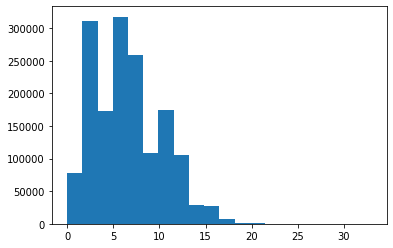

In [17]:
import matplotlib.pyplot as plt
plt.hist(lengths,20)
plt.show()

In [18]:
train_seq = np.array(train_sequences, dtype=object)
df_sequences = pd.DataFrame(train_seq.T, columns=['tokens'])

In [19]:
df_sequences['len'] = df_sequences['tokens'].map(lambda s: len(s))

In [20]:
#data = data.reset_index().drop(['index', 'Unnamed: 0'], axis = 1)
#data

datos = data.reset_index().drop(['index', 'Unnamed: 0'], axis = 1)
datos

,target,ids,date,flag,user,text,raw_text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,aww bummer shoulda got david carr third day,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset updat facebook text might cri result sch...,is upset that he can't update his facebook by ...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,dive mani time ball manag save 50 % rest go bo...,@kenichan i dived many times for the ball. man...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole bodi feel itchi like fire,my whole body feels itchy and like its on fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,behav mad see,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...,...
1591501,1,2193601966,tue jun 16 08:40:49 pdt 2009,no_query,amandamarie1028,woke school best feel ever,just woke up. having no school is the best fee...
1591502,1,2193601969,tue jun 16 08:40:49 pdt 2009,no_query,thewdboards,thewdbcom cool hear old walt interview,thewdb.com - very cool to hear old walt interv...
1591503,1,2193601991,tue jun 16 08:40:49 pdt 2009,no_query,bpbabe,readi mojo makeov ask detail,are you ready for your mojo makeover? ask me f...
1591504,1,2193602064,tue jun 16 08:40:49 pdt 2009,no_query,tinydiamondz,happi 38th birthday boo time tupac amaru shakur,happy 38th birthday to my boo of alll time!!! ...


In [21]:
df_sequences['target'] = datos['target']

In [27]:
df_sequences['len'].quantile(0.95)

13.0

In [28]:
df_sequences

,tokens,len,target
0,"[110, 1066, 3070, 8, 697, 6612, 1665, 3]",8,0
1,"[592, 222, 430, 353, 201, 242, 965, 76, 9, 188...",11,0
2,"[3650, 221, 10, 860, 686, 495, 1071, 344, 1, 2...",10,0
3,"[327, 645, 19, 2548, 6, 863]",6,0
4,"[4066, 454, 18]",3,0
...,...,...,...
1591501,"[248, 76, 103, 19, 149]",5,1
1591502,"[122, 174, 159, 752]",4,1
1591503,"[134, 6123, 6174, 287, 1519]",5,1
1591504,"[53, 183, 296, 10]",4,1


In [29]:
#df_select = df_sequences[(df_sequences.len>9) & (df_sequences.len<11)]

#df_select = df_sequences[df_sequences.len == 10]

df_select = df_sequences

In [30]:
df_select

,tokens,len,target
0,"[110, 1066, 3070, 8, 697, 6612, 1665, 3]",8,0
1,"[592, 222, 430, 353, 201, 242, 965, 76, 9, 188...",11,0
2,"[3650, 221, 10, 860, 686, 495, 1071, 344, 1, 2...",10,0
3,"[327, 645, 19, 2548, 6, 863]",6,0
4,"[4066, 454, 18]",3,0
...,...,...,...
1591501,"[248, 76, 103, 19, 149]",5,1
1591502,"[122, 174, 159, 752]",4,1
1591503,"[134, 6123, 6174, 287, 1519]",5,1
1591504,"[53, 183, 296, 10]",4,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


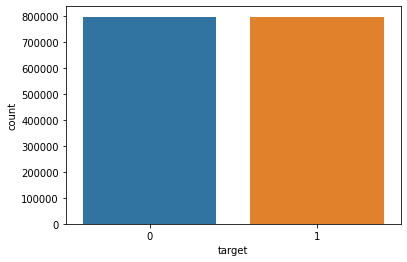

In [31]:
# Revisamos si estan balanceadas las etiquetas
import seaborn as sns
sns.countplot(df_select['target'])

In [32]:
df_select.groupby('target').count()

,tokens,len
target,,
0,796030,796030
1,795476,795476


In [101]:
#last_df = pd.concat([df_select[df_select.target==0].head(46847),df_select[df_select.target==1]], axis=0)

In [33]:
last_df = df_select

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


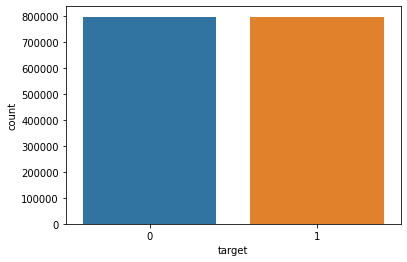

In [34]:
# Revisamos si estan balanceadas las etiquetas
import seaborn as sns
sns.countplot(last_df['target'])

In [35]:
last_df.target

0          0
1          0
2          0
3          0
4          0
          ..
1591501    1
1591502    1
1591503    1
1591504    1
1591505    1
Name: target, Length: 1591506, dtype: int64

# Hacemos padding

In [36]:
#sequences = tokenizer.texts_to_sequences(data_set_1.text)
max_len = 13
tweets = pad_sequences(list(last_df.tokens), maxlen=max_len, padding='post')
print(tweets)

[[ 110 1066 3070 ...    0    0    0]
 [ 592  222  430 ... 1050    0    0]
 [3650  221   10 ...    0    0    0]
 ...
 [ 134 6123 6174 ...    0    0    0]
 [  53  183  296 ...    0    0    0]
 [  53    0    0 ...    0    0    0]]


## Separamos en train, test

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets, last_df.target.values, test_size=0.3, random_state=23042021)

In [38]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1114054, 13)
y_train (1114054,)
X_test (477452, 13)
y_test (477452,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


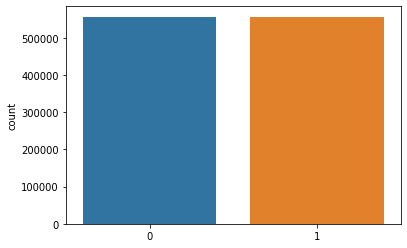

In [39]:
sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


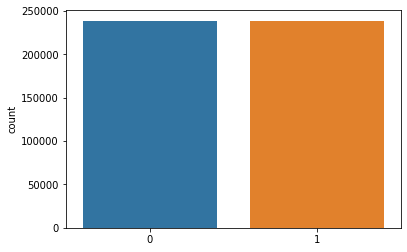

In [40]:
sns.countplot(y_test)

# Creamos el modelo

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l1

# # max_words = 10000 from_logits=True, max_len = 13

In [42]:
model = Sequential()
model.add(Embedding(input_length=max_len, 
                    input_dim=max_words, 
                    output_dim=12, 
                    trainable=True))
model.add(LSTM(units=33))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='rmsprop', metrics=[tf.metrics.BinaryAccuracy(), 
                                            'accuracy'])

In [43]:
history = model.fit(X_train, y_train, epochs=15, batch_size=24, validation_split=0.2)

Epoch 1/15
37136/37136 [==============================] - 242s 6ms/step - loss: 0.5715 - binary_accuracy: 0.7137 - accuracy: 0.7137 - val_loss: 0.4937 - val_binary_accuracy: 0.7643 - val_accuracy: 0.7643
Epoch 2/15
37136/37136 [==============================] - 208s 6ms/step - loss: 0.5418 - binary_accuracy: 0.7471 - accuracy: 0.7471 - val_loss: 0.5048 - val_binary_accuracy: 0.7675 - val_accuracy: 0.7675
Epoch 3/15
37136/37136 [==============================] - 206s 6ms/step - loss: 0.5474 - binary_accuracy: 0.7466 - accuracy: 0.7466 - val_loss: 0.4929 - val_binary_accuracy: 0.7684 - val_accuracy: 0.7684
Epoch 4/15
37136/37136 [==============================] - 206s 6ms/step - loss: 0.5510 - binary_accuracy: 0.7470 - accuracy: 0.7470 - val_loss: 0.4941 - val_binary_accuracy: 0.7683 - val_accuracy: 0.7683
Epoch 5/15
37136/37136 [==============================] - 205s 6ms/step - loss: 0.5483 - binary_accuracy: 0.7484 - accuracy: 0.7484 - val_loss: 0.4973 - val_binary_accuracy: 0.7691 - v

In [44]:
model.evaluate(x=X_test, y=y_test)

14921/14921 [==============================] - 35s 2ms/step - loss: 0.5060 - binary_accuracy: 0.7652 - accuracy: 0.7652


[0.5059911608695984, 0.7651889324188232, 0.7651889324188232]

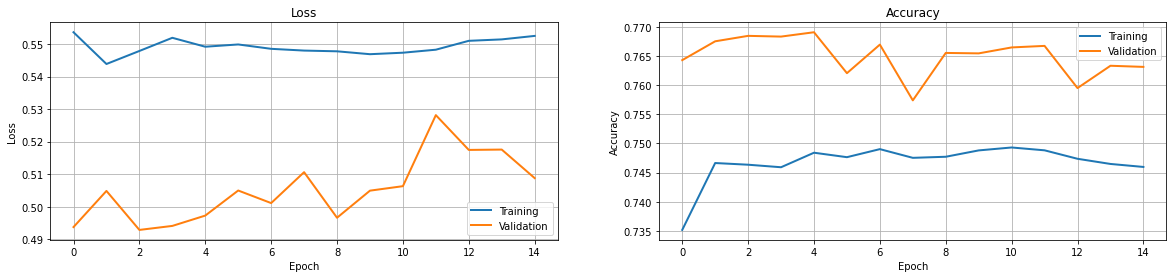

In [45]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [46]:
from tensorflow.keras.models import save_model

In [47]:
save_model(model,"./")

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets
